<a href="https://colab.research.google.com/github/subhayughoshal/CODSOFT/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import re

In [4]:
data = pd.read_csv('Churn_Modelling.csv')

###Data Analysis and cleaning

check for missing values

In [5]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Drop unnecessary columns

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Validate data types

In [7]:
print("\nData Types:\n", data.dtypes)


Data Types:
 CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


Checking for invalid values in numeric columns

In [8]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
for col in numeric_cols:
    if (data[col] < 0).any():
        print(f"Negative values found in {col}")
    else:
        print(f"No negative values in {col}")


No negative values in CreditScore
No negative values in Age
No negative values in Tenure
No negative values in Balance
No negative values in NumOfProducts
No negative values in HasCrCard
No negative values in IsActiveMember
No negative values in EstimatedSalary


Check for unique values in Categorical columns

In [9]:
print("\nUnique Geography values:", data['Geography'].unique())
print("Unique Gender values:", data['Gender'].unique())


Unique Geography values: ['France' 'Spain' 'Germany']
Unique Gender values: ['Female' 'Male']


In [10]:
#Check Target Variable
print("\nUnique Exited values:", data['Exited'].unique())


Unique Exited values: [1 0]


Handle outliers (e.g., cap Age at reasonable values)

In [11]:
data['Age'] = data['Age'].clip(lower=18, upper=100)

encode categorical values

In [12]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])  # Male: 1, Female: 0
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)

##Exploratory Data Analysis (EDA)

###Churn Distribution

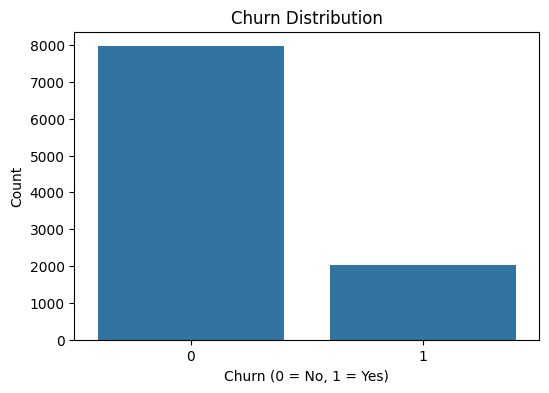

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=data)
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


###Numeric feature distribution

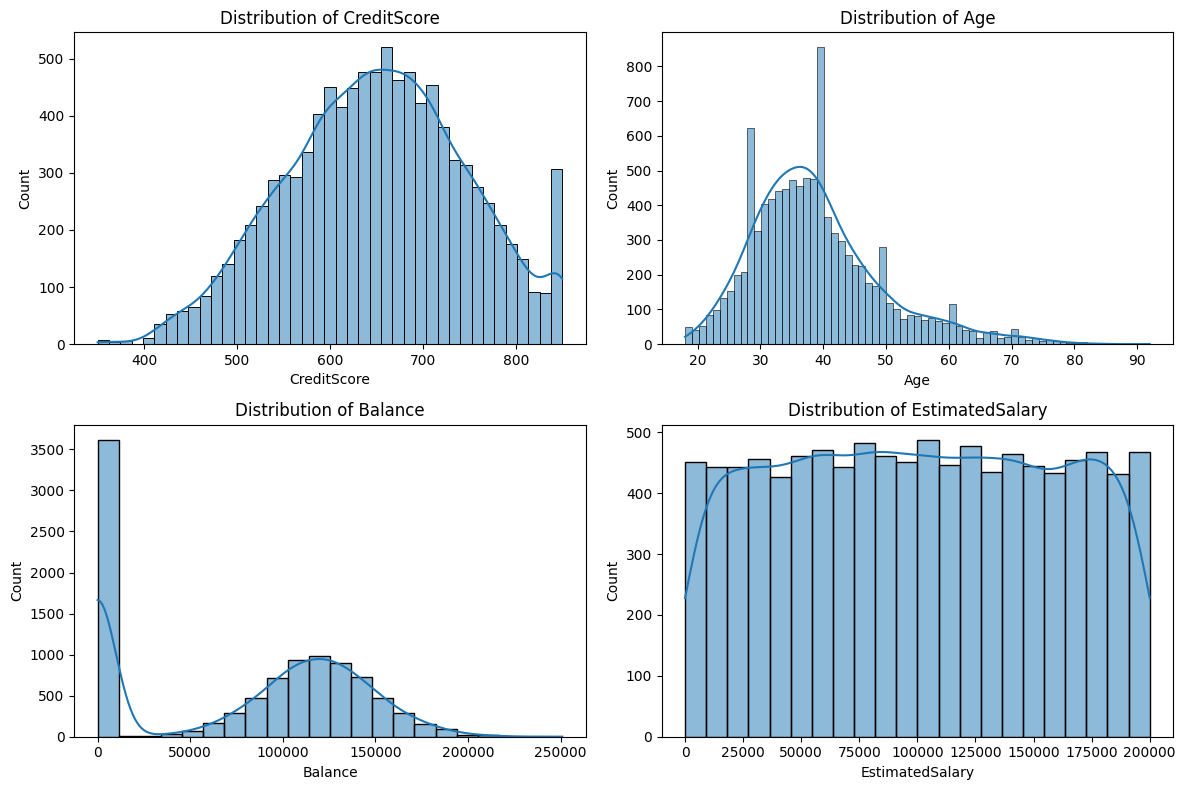

In [14]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(['CreditScore', 'Age', 'Balance', 'EstimatedSalary']):
    plt.subplot(2, 2, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

###Correlation Matrix

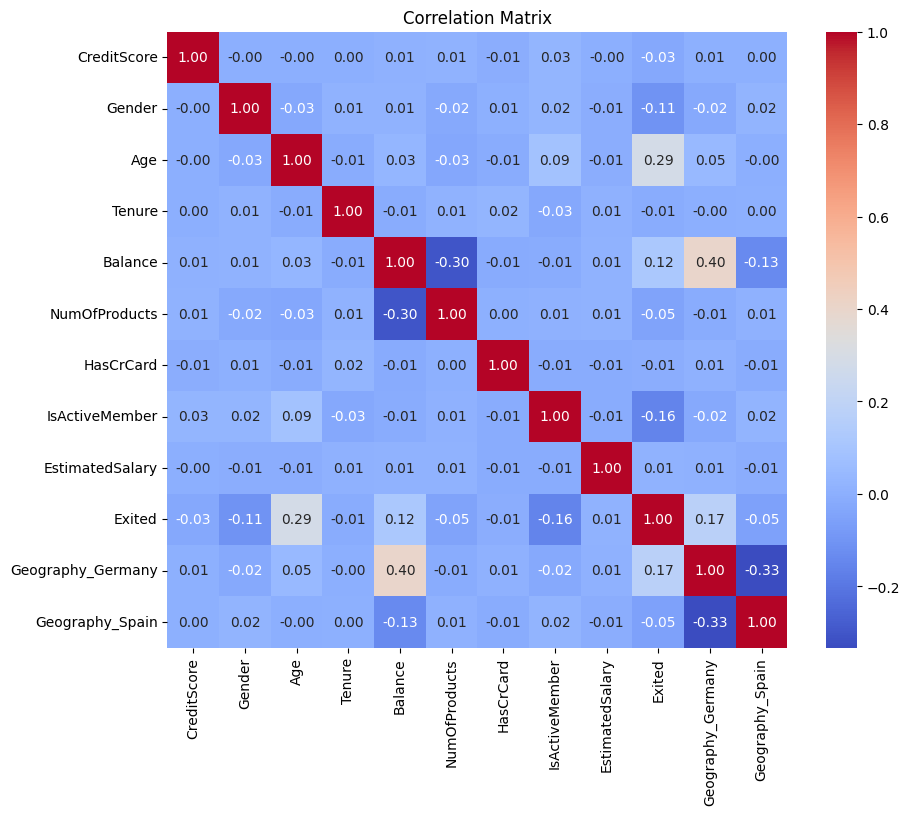

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


###Box plot of Age vs Churn

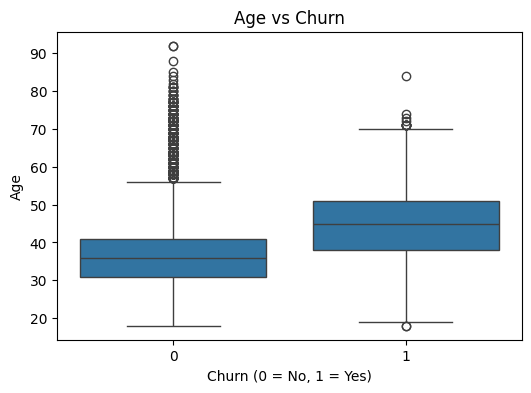

In [16]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Exited', y='Age', data=data)
plt.title('Age vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Age')
plt.show()

###Prepare data for modelling

In [17]:
X = data.drop('Exited', axis=1)
y = data['Exited']


In [18]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Scale numeric features

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training and Evaluation

In [20]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [22]:
# Store metrics
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Print results

In [23]:
print("\nModel Performance:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



Model Performance:

Logistic Regression:
Accuracy: 0.8080
Precision: 0.5891
Recall: 0.1867
F1-Score: 0.2836
ROC-AUC: 0.7748

Random Forest:
Accuracy: 0.8615
Precision: 0.7708
Recall: 0.4545
F1-Score: 0.5719
ROC-AUC: 0.8543

XGBoost:
Accuracy: 0.8530
Precision: 0.6969
Recall: 0.4914
F1-Score: 0.5764
ROC-AUC: 0.8293


###Hyperparameter Tuning for Random Forest

In [24]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Random Forest Parameters:", grid_search.best_params_)
print("Best Random Forest F1-Score:", grid_search.best_score_)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest F1-Score: 0.5844175322079102


###Feature importance(Random Forest)

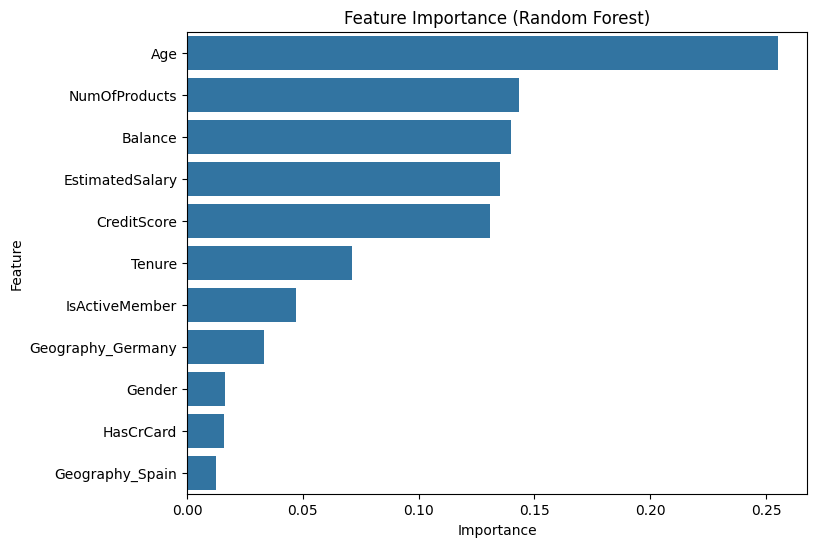

In [25]:
best_rf = grid_search.best_estimator_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.show()

###ROC Curves

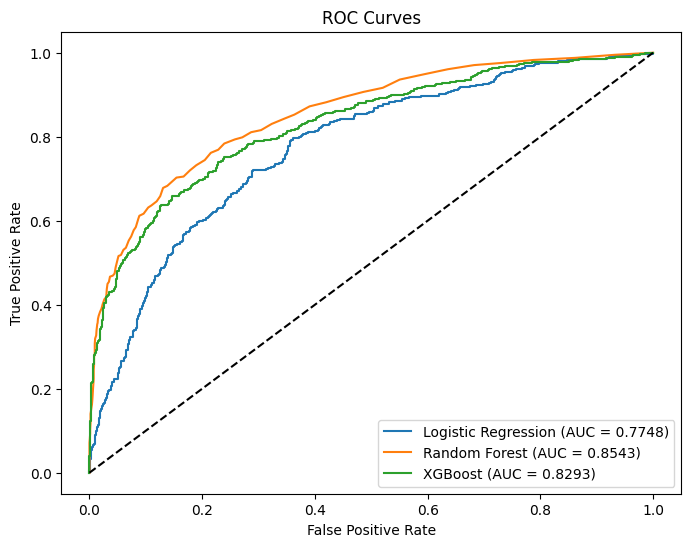

In [26]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()